## Volume Demand Forecast for Multiple Products Using DeepAR in AWS  

### 1. Project introduction and why we using DeepAR algorithm
https://www.kaggle.com/utathya/future-volume-prediction

In [24]:

from __future__ import print_function
%matplotlib inline

from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox


In [25]:
# set random seeds for reproducibility
np.random.seed(4216)
random.seed(4216)

In [29]:
# configure the container image to be used for the region that we are running in. Import the Amazon SageMaker Python SDK and get the deepar container
sagemaker_session = sagemaker.Session()
region = boto3.Session().region_name #sagemaker_session.boto3_region_name  
image_name = get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [30]:
#Get the execution role for the notebook instance. This is the IAM role created for the notebook instance that creates an access b/w S3 bucket and this instance

role = get_execution_role()
#load our data saved in S3 bucket
df_historical_volume = pd.read_csv("s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/historical_volume.csv")
df_price_sales_promotion = pd.read_csv("s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/price_sales_promotion.csv")


In [34]:
df_historical_volume.sample(3)

,Agency,SKU,YearMonth,Volume
12147,Agency_28,SKU_01,201704,36.828
11652,Agency_26,SKU_03,201604,0.000
67,Agency_50,SKU_01,201301,1144.800


In [35]:
df_price_sales_promotion.sample(3)

,Agency,SKU,YearMonth,Price,Sales,Promotions
14719,Agency_29,SKU_05,201407,1847.22027,1793.835005,53.385265
7573,Agency_25,SKU_03,201403,1332.12766,1062.636702,269.490958
6114,Agency_58,SKU_02,201708,1674.31615,1338.204383,336.111767


In [ ]:
# Data cleaning
# manipulate data to the correct format required by SageMaker DeepAR 

In [ ]:
# 3.1 Combining two datasets
# Combine two datasets by 'Agency', 'SKU', 'YearMonth'

In [373]:
df1 = df_historical_volume.sort_values(by = ['Agency', 'SKU', 'YearMonth'], inplace = False, ignore_index = True)
df2 = df_price_sales_promotion.sort_values(by = ['Agency', 'SKU', 'YearMonth'], inplace = False, ignore_index = True)

df = pd.merge(df1, df2, how = 'inner', on = ['Agency', 'SKU', 'YearMonth'])

df['time'] = pd.to_datetime(df['YearMonth'], format = '%Y%m')

In [299]:
### 3.2 Label encoding 
# use label encoders for 2 category variables-- agency and SKU since DeepAR only accepts categories represented by number. We can see agencies and SKUs with their labels below.
# We can see there are 58 agencies and 25 SKUs. It shows below that 'Agency' and it's corresponding label as well as 'SKU' and it's corresponding label




In [273]:
from sklearn import preprocessing
#use label encoding to encode 'Agency' and 'SKU' to numbers 
agency_le = preprocessing.LabelEncoder()
df['Agency_le'] = agency_le.fit_transform(df['Agency'])
sku_le = preprocessing.LabelEncoder()
df['SKU_le'] = sku_le.fit_transform(df['SKU'])

agency_label = agency_le.transform(agency_le.classes_)
agency_name = agency_le.classes_
agency_label_encoder = pd.DataFrame(zip(agency_name, agency_label), columns = ['agency_name', 'agency_label']).to_string(index = False)
sku_label = sku_le.transform(sku_le.classes_)
sku_name = sku_le.classes_
sku_label_encoder = pd.DataFrame(zip(sku_name, sku_label), columns = ['sku_name', 'sku_label']).to_string(index = False)
print(agency_encoder)
print('\t')
print(sku_label_encoder)

agency_name  agency_label
  Agency_01             0
  Agency_02             1
  Agency_03             2
  Agency_04             3
  Agency_05             4
  Agency_07             5
  Agency_08             6
  Agency_09             7
  Agency_10             8
  Agency_11             9
  Agency_12            10
  Agency_13            11
  Agency_15            12
  Agency_16            13
  Agency_17            14
  Agency_18            15
  Agency_19            16
  Agency_20            17
  Agency_21            18
  Agency_22            19
  Agency_23            20
  Agency_24            21
  Agency_25            22
  Agency_26            23
  Agency_27            24
  Agency_28            25
  Agency_29            26
  Agency_30            27
  Agency_31            28
  Agency_32            29
  Agency_33            30
  Agency_34            31
  Agency_35            32
  Agency_36            33
  Agency_37            34
  Agency_38            35
  Agency_39            36
  Agency_40 

In [ ]:
### 3.3 Transformation of the data format
#We start to transform data from a vertical format to a dictionary format using group_by and merge etc. After grouping the data by 'Agency' and 'SKU', we can see we have 350 time series that we will need to predict simultaneously 

In [300]:
group_by = df.groupby(['Agency_le', 'SKU_le']) # cat: 350 agency-SKU combination time series in total
volume_series = group_by['Volume'].apply(list).reset_index(name = 'volume')
sales_series = group_by['Sales'].apply(list).reset_index(name = 'sales')
promotion_series = group_by['Promotions'].apply(list).reset_index(name = 'promotions')

df_merge = pd.merge(volume_series, sales_series, how= 'inner', on= ['Agency_le','SKU_le']) 
df_merge2 = pd.merge(df_merge, promotion_series, how = 'inner', on = ['Agency_le','SKU_le'])
#df_merge2['cat_agency_sku'] = df_merge2[['Agency_le', 'SKU_le']].apply(lambda x: ','.join(x.map(str)), axis=1)
df_merge2['cat_agency_sku'] = df_merge2[['Agency_le', 'SKU_le']].apply(lambda x: list(x), axis=1)

#check the lengths of each dynamic features.len should be 60.

np.where(df_merge2.volume.apply(lambda x: len(x)) != 60)
np.where(df_merge2.sales.apply(lambda x: len(x)) !=60)
np.where(df_merge2.promotions.apply(lambda x: len(x)) !=60)

(array([], dtype=int64),)

In [754]:
# monthly volume, sales and promotions for each agency and sku averaged over 2013-2017
Agency_SKU = df.groupby(['Agency','SKU'])
Agency_SKU_mean = Agency_SKU['Volume'].mean().reset_index(name = 'average_volume')
Agency_SKU_mean.sample(3)

,Agency,SKU,average_volume
87,Agency_16,SKU_04,1040.106178
9,Agency_02,SKU_04,4078.060653
181,Agency_31,SKU_03,592.906040


In [ ]:
###3.4 spliting data to training and test sets
# training set: 48-month data from 2013-01 to 2016-12
#test set:12-month data from 2017-01 to 2017-12


In [303]:
df_merge2['sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['sales']),np.array(x['promotions'])]),axis = 1)
df_merge2['training_volume'] = df_merge2['volume'].apply(lambda x: x[:48])
df_merge2['training_sales'] = df_merge2['sales'].apply(lambda x: x[:48])
df_merge2['training_promotions'] = df_merge2['promotions'].apply(lambda x: x[:48])
df_merge2['training_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['training_sales']),np.array(x['training_promotions'])]),axis = 1)

df_merge2['test_volume'] = df_merge2['volume'].apply(lambda x: x[48:])
df_merge2['test_sales'] = df_merge2['sales'].apply(lambda x: x[48:])
df_merge2['test_promotions'] = df_merge2['promotions'].apply(lambda x: x[48:])
df_merge2['test_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['test_sales']),np.array(x['test_promotions'])]),axis = 1)

# create the dynamic_feat: sales and promotions for batch transform data. 
df_merge2['batch_sales'] = df_merge2.apply(lambda x: x.sales + x.test_sales, axis = 1)
df_merge2['batch_promotions'] = df_merge2.apply(lambda x: x.promotions + x.test_promotions, axis = 1)
df_merge2['batch_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['batch_sales']),np.array(x['batch_promotions'])]),axis = 1)

In [757]:
full_df_clean = pd.concat([df_merge2,Agency_SKU_mean], axis = 1)
full_df_clean.sample(3)

,Agency_le,SKU_le,volume,sales,promotions,cat_agency_sku,training_volume,training_sales,training_promotions,training_sales_promotions,...,test_sales,test_promotions,test_sales_promotions,batch_sales,batch_promotions,batch_sales_promotions,sales_promotions,Agency,SKU,average_volume
126,20,0,"[42.443999999999996, 39.635999999999996, 33.69...","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[20, 0]","[42.443999999999996, 39.635999999999996, 33.69...","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[[1060.82236, 1059.24404, 1096.6482369999999, ...",...,"[1313.624556, 1321.591404, 1313.194334, 1239.6...","[316.990373, 322.471096, 330.86816600000003, 4...","[[1313.624556, 1321.591404, 1313.194334, 1239....","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[[1060.82236, 1059.24404, 1096.6482369999999, ...","[[1060.82236, 1059.24404, 1096.6482369999999, ...",Agency_23,SKU_01,41.333400
136,21,4,"[433.6893, 436.2453, 558.8055, 560.4669, 639.0...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[21, 4]","[433.6893, 436.2453, 558.8055, 560.4669, 639.0...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[[1195.790835, 1197.118984, 1236.672614, 1291....",...,"[1520.4862, 1476.422039, 1461.040886, 1387.006...","[240.48908500000002, 279.967596, 287.832221, 3...","[[1520.4862, 1476.422039, 1461.040886, 1387.00...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[[1195.790835, 1197.118984, 1236.672614, 1291....","[[1195.790835, 1197.118984, 1236.672614, 1291....",Agency_24,SKU_05,507.508395
330,55,2,"[229.68900000000002, 273.258, 371.2248, 298.38...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[55, 2]","[229.68900000000002, 273.258, 371.2248, 298.38...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[[1164.8596730000002, 1152.550517, 1208.036876...",...,"[1368.17466, 1415.8808390000002, 1394.083991, ...","[292.504778, 259.806903, 296.47146000000004, 3...","[[1368.17466, 1415.8808390000002, 1394.083991,...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[[1164.8596730000002, 1152.550517, 1208.036876...","[[1164.8596730000002, 1152.550517, 1208.036876...",Agency_58,SKU_03,301.496200


In [ ]:
## #3.5 Transforming training and test sets to dictionary format
# Transforming to dictionary format to be prepared for json line format required by DeepAR

In [422]:
start_training = pd.Timestamp("2013-01-01 00:00:00")


training_data = []
for _,row in df_merge2.iterrows():
    training_dic = {"start": str(start_training),
           "target": row['training_volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['training_sales_promotions'] 
           }
    training_data.append(training_dic)

    

test_data = []
for _,row in df_merge2.iterrows():
    test_dic = {"start": str(start_training),
           "target": row['volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['sales_promotions'] 
           }
    test_data.append(test_dic)


# create batch transform input: predicting volume demand for each SKU and agency pair for 201801 - 201812 given dynamic_feat--'sales' and 'promotions' remain the same as of 2017
batch_transform_input = []
for _,row in df_merge2.iterrows():
    batch_dic = {"start": str(start_training),
           "target": row['volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['batch_sales_promotions'] 
           }
    batch_transform_input.append(batch_dic)

    
    
#dataset for calculating predicted volume for each series in the test set
data_for_calculating_predicted = []
for _,row in df_merge2.iterrows():
    calculating_predicted_dic = {"start": str(start_training),
           "target": row['training_volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['sales_promotions'] 
           }
    data_for_calculating_predicted.append(calculating_predicted_dic)

In [ ]:
### 3.6 Transforming dictionary to json lines

In [423]:
import json 

# correct np narray
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# convert to json lines: each line is a json object
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d, cls=NumpyEncoder).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)
write_dicts_to_file("batch_transform_input.json", batch_transform_input)
write_dicts_to_file("data_for_calculating_predicted.json", data_for_calculating_predicted)

#### 3.7 Copying the local json lines to S3 where DeepAR can access

In [424]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [425]:
BUCKET_NAME = 'sagemaker-us-east-2-939910653043'
upload_file("train.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data/train.json")
upload_file("test.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data/test.json")
upload_file("batch_transform_input.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/batch_transform_input.json")
upload_file("data_for_calculating_predicted.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data_for_calculating_predicted.json")

True

In [541]:
# have a look to what was just written to S3. Now data has been successfully customized to json line which is required by DeepAR
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/data/test.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:500] + "...")

{"start": "2013-01-01 00:00:00", "target": [80.676, 98.064, 133.704, 147.312, 175.608, 180.792, 149.796, 161.136, 147.744, 149.364, 95.36399999999999, 104.544, 100.54799999999999, 123.552, 125.17200000000001, 70.524, 21.924, 66.744, 89.1, 107.352, 100.87200000000001, 113.292, 68.148, 75.492, 41.58, 58.32, 87.37200000000001, 81.0, 91.90799999999999, 86.616, 135.0, 97.632, 103.464, 92.016, 54.864, 40.608000000000004, 55.836000000000006, 52.812, 88.992, 66.63600000000001, 49.14, 4.32, 54.4319999999...


## 4. Train the DeepAR model

In [ ]:
#### 4.1 Training a model
#After specifying the hyperparameters below, we trained a DeepAR model with the training set. Meanwhile, the built-in function let us test the model with the test set. As we can see below, the test error was obtained: test RMSE <loss>=759.711203642

In [431]:
s3_output_path = "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/output"

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name='deepar-volume-demand-forecast',
    output_path=s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [432]:
hyperparameters = {
    "time_freq":"M" ,
    "cardinality" : "auto",
    "num_dynamic_feat":"auto",
    "epochs": "162",       
    "dropout_rate": "0.1",
    "embedding_dimension" : "10",
    "likelihood":"gaussian",
    "num_cells": "94",
    "num_layers": "4",
    "mini_batch_size":"256",
    #"learning_rate": "1e-3",
    "num_eval_samples": "100",
    "test_quantiles": "[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]",
    "context_length": "12",
    "prediction_length": "12"}
estimator.set_hyperparameters(**hyperparameters)

In [434]:
%%time
data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"
}

estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-11-08 09:42:51 Starting - Starting the training job...
2020-11-08 09:42:53 Starting - Launching requested ML instances......
2020-11-08 09:43:58 Starting - Preparing the instances for training...
2020-11-08 09:44:33 Downloading - Downloading input data
2020-11-08 09:44:33 Training - Downloading the training image...
2020-11-08 09:45:06 Training - Training image download completed. Training in progress.Arguments: train
[11/08/2020 09:45:08 INFO 140482535282496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto'

In [ ]:
#### 4.2 Hyperparamter Tuning for multiple DeepAR models with auto-tuning function
# We chose 5 hyperparameters considered to having bigger impact on the performance of the model such as learning rate and minibatch size. Then, we searched the best values of them within the specified ranges to have the lowest test error. We trained 6 models in total and the best model has the test RMSE: 2390.21630859375, which is significantly improved compared with our first model(test RMSE: 3077). 

In [439]:
s3_output_path_auto = "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/output_auto"

estimator_auto = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name='deepar-volume-demand-forecast-autotuning',
    output_path=s3_output_path_auto
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [440]:
hyperparameters_auto = {
    "time_freq":"M" ,
    "cardinality" : "auto",
    "num_dynamic_feat":"auto",
    #"epochs": "162",
    "dropout_rate": "0.1",
    "embedding_dimension" : "10",
    "likelihood":"gaussian",
    #"num_cells": "50",
    #"num_layers": "4",
    #"mini_batch_size":"256",
    #"learning_rate": "1e-3",
    "num_eval_samples": "100",
    "test_quantiles": "[0.1, 0.5, 0.9]",
    #"context_length": "12",
    "prediction_length": "12"}
estimator_auto.set_hyperparameters(**hyperparameters_auto)

In [441]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
hyperparameter_ranges = {"learning_rate": ContinuousParameter(1e-4, 1e-1),
                         "mini_batch_size": IntegerParameter(128, 350),
                         "epochs": IntegerParameter(10, 500),
                         "context_length":IntegerParameter(12, 24),
                         "num_cells":IntegerParameter(30, 200),
                         "num_layers": IntegerParameter(1, 8)
                        }

In [442]:
objective_metric_name = "test:RMSE" # start with "test:"  can be found on the website
# the order of the params in the hyperparametertuner matters
tuner = HyperparameterTuner(estimator_auto,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions=None,
                            strategy="Bayesian",
                            objective_type="Minimize",
                            max_jobs=6,
                            max_parallel_jobs=3,
                            tags=None,
                            base_tuning_job_name='deepar-auto-tuner')

data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"}

#s3_input_train = sagemaker.s3_input(s3_data="s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train", content_type='json')
#s3_input_test = sagemaker.s3_input(s3_data="s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test", content_type='json')

tuner.fit(inputs = data_channels,logs=True, include_cls_metadata=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [ ]:
#### 4.3 Auto-tuning the hyperparamters with a warm_start
#We wanted to keep improving the performace of our model, so we tuned the parameters from last step. 

In [499]:
from sagemaker.tuner import WarmStartConfig,WarmStartTypes

parent_tuning_job_name = "deepar-auto-tuner-201108-1008"
warm_start_config = WarmStartConfig(WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name})


In [500]:
objective_metric_name = "test:RMSE" # start with "test:" that can be found on the website
# the order of the params in the hyperparametertuner matters
tuner_warm_start = HyperparameterTuner(estimator_auto,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions=None,
                            strategy="Bayesian",
                            objective_type="Minimize",
                            max_jobs=2,
                            max_parallel_jobs=2,
                            tags=None,
                            base_tuning_job_name='deepar-warm-start',
                            warm_start_config=warm_start_config)

data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"}

#s3_input_train = sagemaker.s3_input(s3_data="s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train", content_type='json')
#s3_input_test = sagemaker.s3_input(s3_data="s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test", content_type='json')

tuner_warm_start.fit(inputs = data_channels,logs=True, include_cls_metadata=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [531]:
# we did auto hyperparameter tuning jobs with a warm start twice. It shows both of them below.
tuning_job_name = 'deepar-warm-start-201108-1212'
tuner_parent = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
full_df = tuner_parent.dataframe()
full_df.sort_values(['FinalObjectiveValue'], ascending=True)

,context_length,epochs,learning_rate,mini_batch_size,num_cells,num_layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,14.0,62.0,0.002802,302.0,131.0,4.0,deepar-warm-start-201108-1212-001-d4156b30,Completed,7317.977539,2020-11-08 12:14:12+00:00,2020-11-08 12:23:06+00:00,534.0
0,22.0,492.0,0.000161,206.0,170.0,2.0,deepar-warm-start-201108-1212-002-41338e93,Completed,7466.051758,2020-11-08 12:14:12+00:00,2020-11-08 12:55:31+00:00,2479.0


In [534]:
#test predcited vs actual

PREFIX = "product-demand-forecast-deepar"

batch_input_test = 's3://{}/{}/data_for_calculating_predicted'.format(BUCKET_NAME, PREFIX)

# The location to store the results of the batch transform job
batch_output_test = 's3://{}/{}/predicted_values_testset'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 100, \"output_types\": [\"mean\"] }"}
transformer_test = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env,output_path=batch_output_test)
# SplitType must be set according to the ContentType of the input data.
transformer_test.transform(data=batch_input_test, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')

#transformer_test.wait()

Arguments: serve
Arguments: serve
No handlers could be found for logger "root"
[11/05/2020 13:43:29 INFO 140167278716736] Estimated memory required per model 32MB.
[11/05/2020 13:43:29 INFO 140167278716736] Estimated available memory 14891MB.
[11/05/2020 13:43:29 INFO 140167278716736] Estimated maximum number of workers for the available memory is 452.
[11/05/2020 13:43:29 INFO 140167278716736] Using 4 workers
[11/05/2020 13:43:29 INFO 140167278716736] loading entry points
[11/05/2020 13:43:29 INFO 140167278716736] Prediction endpoint operating in batch mode
[11/05/2020 13:43:29 INFO 140167278716736] loaded request iterator application/jsonlines
[11/05/2020 13:43:29 INFO 140167278716736] loaded response encoder application/jsonlines
[11/05/2020 13:43:29 INFO 140167278716736] loaded model class model
[11/05/2020 13:43:29 WARNING 140167278716736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/05/2020 13:43:29 INFO 140167278716736] nvidia-smi took: 0.025193

In [644]:
######plot predicted vs actual for test set
predicted = []
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/predicted_values_testset/data_for_calculating_predicted.json.out", 'rb') as f:
    pred = json.loads("[" + f.read().decode("utf-8").replace("}{", "},\n{") + "]") #json.loads() only takes str and return dic

pred_test = pd.DataFrame(pred).rename(columns={"mean": "predicted_volume"})
pred_actual_testset = pd.concat([full_df_clean[['cat_agency_sku','Agency','SKU','test_volume']],pred_test], axis = 1).rename(columns={"test_volume": "actual_volume"})

In [ ]:
####################
batch_output_test_median = 's3://{}/{}/predicted_values_testset_median'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env_median ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 100, \"output_types\": [\"quantiles\"] ,}"}
transformer_test = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env,output_path=batch_output_test)
# SplitType must be set according to the ContentType of the input data.
transformer_test.transform(data=batch_input_test, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')

predicted = []
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/predicted_values_testset/data_for_calculating_predicted.json.out", 'rb') as f:
    pred = json.loads("[" + f.read().decode("utf-8").replace("}{", "},\n{") + "]") #json.loads() only takes str and return dic

pred_test = pd.DataFrame(pred).rename(columns={"mean": "predicted_volume"})

In [761]:
full_data = pd.concat([full_df_clean ,pred_test], axis = 1).rename(columns={"test_volume": "actual_volume"})
full_data.to_csv('clean_full_data.csv')
full_data.sample(3)

,Agency_le,SKU_le,volume,sales,promotions,cat_agency_sku,training_volume,training_sales,training_promotions,training_sales_promotions,...,test_promotions,test_sales_promotions,batch_sales,batch_promotions,batch_sales_promotions,sales_promotions,Agency,SKU,average_volume,predicted_volume
135,21,3,"[44.0271, 69.9066, 149.526, 71.5041, 101.8566,...","[1592.180288, 1591.233232, 1648.486412, 1694.1...","[149.93238799999997, 150.879444, 157.987044, 1...","[21, 3]","[44.0271, 69.9066, 149.526, 71.5041, 101.8566,...","[1592.180288, 1591.233232, 1648.486412, 1694.1...","[149.93238799999997, 150.879444, 157.987044, 1...","[[1592.180288, 1591.233232, 1648.486412, 1694....",...,"[370.999381, 396.312046, 467.479862, 390.35634...","[[1916.3973210000001, 1901.830275, 1825.01777,...","[1592.180288, 1591.233232, 1648.486412, 1694.1...","[149.93238799999997, 150.879444, 157.987044, 1...","[[1592.180288, 1591.233232, 1648.486412, 1694....","[[1592.180288, 1591.233232, 1648.486412, 1694....",Agency_24,SKU_04,79.192760,"[85.8805770874, 84.3068237305, 84.4783859253, ..."
299,50,4,"[4390.7607, 4419.516, 5303.12475, 5439.999, 62...","[1287.0734, 1280.34249, 1305.731636, 1348.6403...","[20.408811, 27.402631, 28.201117, 27.276829, 2...","[50, 4]","[4390.7607, 4419.516, 5303.12475, 5439.999, 62...","[1287.0734, 1280.34249, 1305.731636, 1348.6403...","[20.408811, 27.402631, 28.201117, 27.276829, 2...","[[1287.0734, 1280.34249, 1305.731636, 1348.640...",...,"[202.921278, 378.661044, 384.747206, 441.31205...","[[1598.578772, 1441.418288, 1432.510331, 1377....","[1287.0734, 1280.34249, 1305.731636, 1348.6403...","[20.408811, 27.402631, 28.201117, 27.276829, 2...","[[1287.0734, 1280.34249, 1305.731636, 1348.640...","[[1287.0734, 1280.34249, 1305.731636, 1348.640...",Agency_53,SKU_05,6271.748088,"[5776.248046875, 5913.4711914062, 5841.8085937..."
274,46,6,"[3.0975, 2.2125, 1.77, 8.4075, 4.425, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[46, 6]","[3.0975, 2.2125, 1.77, 8.4075, 4.425, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,"[0.0, 4.768221, 0.0, 57.456991, 79.34586800000...","[[0.0, 1640.998729, 0.0, 1578.773517, 1556.884...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Agency_49,SKU_07,5.450125,"[1.615773201, 3.4867076874, 0.302464366, 4.111..."


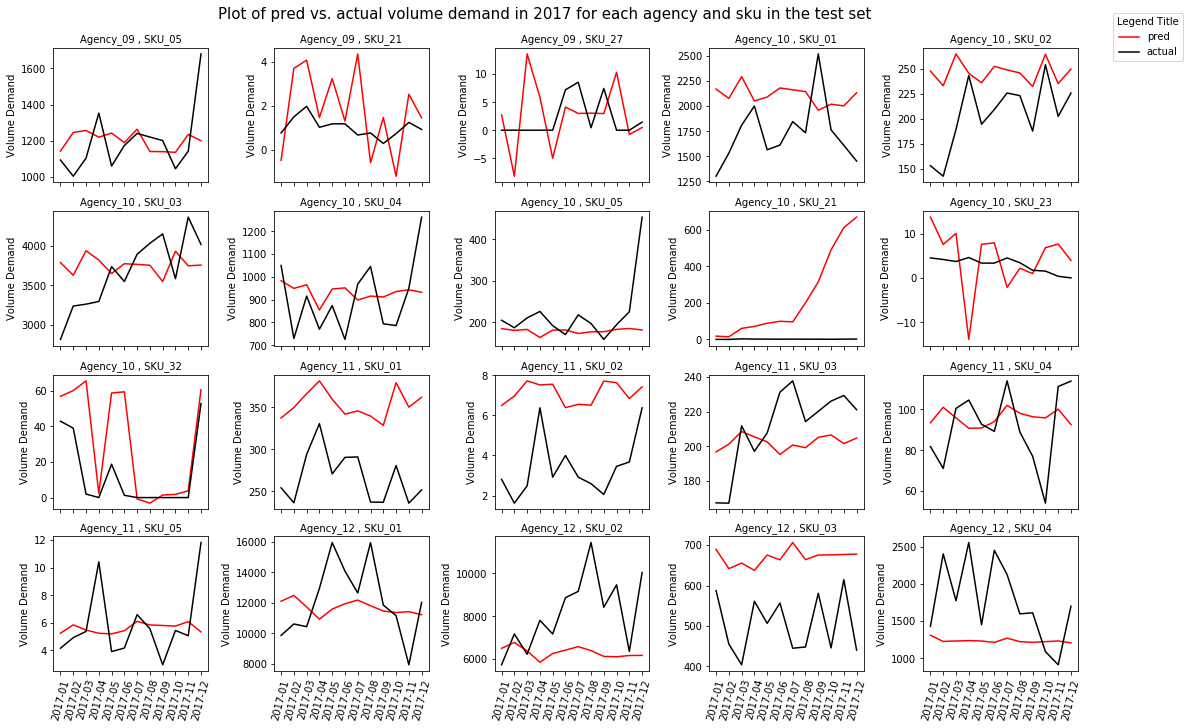

In [784]:
test_period_range = pd.period_range(start='2017-01-01', end='2017-12-01', freq='M').strftime('%Y-%m')

import matplotlib.pyplot as plt

def compare_pred_actual_plot(ax, row):
    ax.plot(test_period_range,full_data.loc[row,'predicted_volume'], color = 'red', label = 'pred')
    ax.plot(test_period_range,full_data.loc[row,'actual_volume'],color = 'black', label = 'actual')
    ax.set_title(full_data.loc[row,'Agency']+' , '+full_data.loc[row,'SKU'] , fontsize=10)
    ax.set_ylabel('Volume Demand', fontsize=10)
    ax.set_xticklabels(test_period_range, rotation=75)


fig, axs = plt.subplots(nrows=4, ncols=5, constrained_layout=True,figsize=(15,10),sharex=True)

for ax, row in zip(axs.flat,range(50,70,1)): 
    compare_pred_actual_plot(ax, row)
    
fig.legend( labels = ['pred','actual'],bbox_to_anchor=(0.8, 0.8, 0.3, 0.2), loc="upper right", title="Legend Title")
fig.suptitle('Plot of pred vs. actual volume demand in 2017 for each agency and sku in the test set', fontsize=15)
fig.savefig('Plot of pred vs. actual volume demand in 2017 50-70.png')


## Create endpoint and predictor

In [210]:
# the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [818]:
#deploy the best model out of 20 models
#best_model_name = 'volume-demand-deepar-model'
#predictor =estimator.deploy(initial_instance_count = 1, instance_type ='ml.c5.2xlarge',endpoint_name='predict-volume-deepar-endpoint', wait=True)

### Make predictions and plot results

In [838]:
#predict a new agency_01, sku_07 : [0,6]
request_Agency1_sku7 = json.dumps(
{
    "instances":[
    
        {
            'start':str(pd.Timestamp("2017-01-01 00:00:00")),
            'target':[],
            'cat':[0,6],
            'dynamic_feat':[[1321,1464,1432,1422,1422,1443,1432,1432,1403,1466,1428,1426], #median sales
                            [20,47,117,128,146,104,120,148,174,99,91,114]] #median promotions
        }
    ],
    
    "configuration":{'num_samples':100, 'output_types':['mean', 'quantiles'],'quantiles': ['0.5', '0.9']}
    
}
) 
endpoint_name = 'predict-volume-deepar-endpoint'
#predictor = RealTimePredictor(endpoint=endpoint_name)

#predictor.predict(data = request_Agency1_sku7)
import boto3
client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=request_Agency1_sku7)

In [839]:
content = response['Body'].read().decode('utf-8')
content

'{"predictions":[{"quantiles":{"0.9":[1843.3134765625,1838.8564453125,2016.5388183594,2099.3859863281,2176.3139648438,2208.5234375,2207.9533691406,2056.2502441406,2130.9462890625,2134.4799804688,2219.1831054688,2186.8801269531],"0.5":[802.2844848633,1335.1602783203,1385.9836425781,1465.619140625,1525.7822265625,1561.7410888672,1615.8662109375,1495.8974609375,1548.1202392578,1510.1351318359,1441.0704345703,1517.4377441406]},"mean":[793.0969238281,1313.3209228516,1395.6217041016,1485.7294921875,1545.9248046875,1576.5805664062,1592.3856201172,1481.2973632812,1552.5479736328,1506.3107910156,1460.4992675781,1497.7219238281]}]}'

## Making prediction with the best model using batch transform
Based on the data we have from 2013-01 to 2017-12, we will predict the volume demand for 350 Agency and SKU pairs between 2018-01 to 2018-12 with the best model(test RMSE: 805) we have so far using batch transform. We will set the  dynamic features for sales and promotions for 2018 the same as the year 2017 for the 350 time seires.

In [376]:
#
tuner_warm_start.best_estimator()

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-03 07:18:20 Starting - Preparing the instances for training
2020-10-03 07:18:20 Downloading - Downloading input data
2020-10-03 07:18:20 Training - Training image download completed. Training in progress.
2020-10-03 07:18:20 Uploading - Uploading generated training model
2020-10-03 07:18:20 Completed - Training job completedArguments: train
[10/03/2020 07:10:12 INFO 140013755713344] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/03/2020 

In [ ]:
##### creating the dateset for batch transform job
#create the dataset and save it as json lines in S3 bucket.

In [536]:
# predict volume demand for every SKU and agency pair for Jan, 2018 - Dec, 2018 given setting sales and promotions the same as the previous 12 months respectively 
PREFIX = "product-demand-forecast-deepar"

batch_input_predict2018 = 's3://{}/{}/batch_transform_input'.format(BUCKET_NAME, PREFIX)

# The location to store the results of the batch transform job
batch_output_predict2018 = 's3://{}/{}/batch_inference_predict2018'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 100, \"output_types\": [\"mean\"] }"}
transformer_predict2018 = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env,output_path=batch_output_predict2018)
# SplitType must be set according to the ContentType of the input data.
transformer_predict2018.transform(data=batch_input_predict2018, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')

transformer_predict2018.wait()

...............................Arguments: serve
No handlers could be found for logger "root"
[11/09/2020 06:21:28 INFO 139874992023360] Estimated memory required per model 33MB.
[11/09/2020 06:21:28 INFO 139874992023360] Estimated available memory 14862MB.
[11/09/2020 06:21:28 INFO 139874992023360] Estimated maximum number of workers for the available memory is 437.
[11/09/2020 06:21:28 INFO 139874992023360] Using 4 workers
[11/09/2020 06:21:28 INFO 139874992023360] loading entry points
[11/09/2020 06:21:28 INFO 139874992023360] Prediction endpoint operating in batch mode
[11/09/2020 06:21:28 INFO 139874992023360] loaded request iterator application/jsonlines
[11/09/2020 06:21:28 INFO 139874992023360] loaded response encoder application/jsonlines
[11/09/2020 06:21:28 INFO 139874992023360] loaded model class model
[11/09/2020 06:21:28 WARNING 139874992023360] Requesting context without setting the requested num of gpus. Using 'auto'
[11/09/2020 06:21:28 INFO 139874992023360] nvidia-smi 

In [377]:
tuner_warm_start1.best_training_job()

'warmstart-201003-0707-001-60039ae0'

In [213]:
predictor.delete_endpoint()